In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tushare as ts

tf.random.set_seed(8)

pro = ts.pro_api()
pro = ts.pro_api('107616fccaaf92567ab2299cf5b6ce3b5044922d11045bebe6664811')

df = ts.get_k_data('600028', start='2021-03-01', end='2021-12-31')
# df = pd.concat([data.DataReader(t, source, start, end) for t in tickers]).reset_index()
dates = df["date"]
df


本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


/opt/anaconda3/lib/python3.9/site-packages/tushare/stock/trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


,date,open,close,high,low,volume,code
35,2021-03-01,3.94,3.97,3.99,3.86,2132957.0,600028
36,2021-03-02,3.91,3.78,3.91,3.73,3262558.0,600028
37,2021-03-03,3.75,3.86,3.88,3.75,2360436.0,600028
38,2021-03-04,3.86,3.85,3.91,3.81,1632436.0,600028
39,2021-03-05,3.92,3.90,3.98,3.81,2489610.0,600028
...,...,...,...,...,...,...,...
238,2021-12-27,3.90,3.94,3.94,3.89,1026200.0,600028
239,2021-12-28,3.95,3.93,3.96,3.91,840632.0,600028
240,2021-12-29,3.93,3.93,3.94,3.90,647881.0,600028
241,2021-12-30,3.92,3.91,3.93,3.91,894462.0,600028


In [2]:
cols = list(df)[1:3]
df_train = df[cols].astype(float)
df_train
# df_plt = df_train.tail(5000)
# df_plt.plot.line()

,open,close
35,3.94,3.97
36,3.91,3.78
37,3.75,3.86
38,3.86,3.85
39,3.92,3.90
...,...,...
238,3.90,3.94
239,3.95,3.93
240,3.93,3.93
241,3.92,3.91


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(df_train)
scaled

array([[0.48387097, 0.51578947],
       [0.4516129 , 0.31578947],
       [0.27956989, 0.4       ],
       [0.39784946, 0.38947368],
       [0.46236559, 0.44210526],
       [0.53763441, 0.50526316],
       [0.4516129 , 0.46315789],
       [0.43010753, 0.35789474],
       [0.38709677, 0.42105263],
       [0.44086022, 0.42105263],
       [0.40860215, 0.55789474],
       [0.52688172, 0.49473684],
       [0.46236559, 0.4       ],
       [0.38709677, 0.37894737],
       [0.2688172 , 0.18947368],
       [0.19354839, 0.22105263],
       [0.21505376, 0.18947368],
       [0.12903226, 0.14736842],
       [0.17204301, 0.15789474],
       [0.12903226, 0.16842105],
       [0.21505376, 0.22105263],
       [0.24731183, 0.25263158],
       [0.23655914, 0.26315789],
       [0.24731183, 0.23157895],
       [0.25806452, 0.25263158],
       [0.22580645, 0.22105263],
       [0.21505376, 0.29473684],
       [0.2688172 , 0.29473684],
       [0.29032258, 0.32631579],
       [0.32258065, 0.32631579],
       [0.

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(scaled, test_size=0.25, random_state=0)
print(train.shape)
print(test.shape)

(156, 2)
(52, 2)


In [5]:
days_future = 7
days_past = 14

train_X = []
train_y = []
test_X = []
test_y = []

for i in range(days_past, len(train) - days_future + 1):
    train_X.append(train[i - days_past:i, 0:train.shape[1]])
    train_y.append(train[i + days_future - 1:i + days_future, 0])
    
for i in range(days_past, len(test) - days_future + 1):
    test_X.append(test[i - days_past:i, 0:train.shape[1]])
    test_y.append(test[i + days_future - 1:i + days_future, 0])
    
train_X, train_y, test_X, test_y = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)
    
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(136, 14, 2)
(136, 1)
(32, 14, 2)
(32, 1)


In [6]:
# To solve the problem: To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
# Don't know why, just copy this solution of CSDN
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Layer
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 64, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False, dropout=0.5))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17152     
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 62,625
Trainable params: 62,625
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=1)

Epoch 1/10
3/3 [==============================] - 5s 536ms/step - loss: 0.1437 - val_loss: 0.1365
Epoch 2/10
3/3 [==============================] - 0s 44ms/step - loss: 0.0694 - val_loss: 0.0833
Epoch 3/10
3/3 [==============================] - 0s 35ms/step - loss: 0.0411 - val_loss: 0.0913
Epoch 4/10
3/3 [==============================] - 0s 34ms/step - loss: 0.0519 - val_loss: 0.0818
Epoch 5/10
3/3 [==============================] - 0s 37ms/step - loss: 0.0418 - val_loss: 0.0833
Epoch 6/10
3/3 [==============================] - 0s 41ms/step - loss: 0.0389 - val_loss: 0.0870
Epoch 7/10
3/3 [==============================] - 0s 37ms/step - loss: 0.0417 - val_loss: 0.0846
Epoch 8/10
3/3 [==============================] - 0s 40ms/step - loss: 0.0403 - val_loss: 0.0809
Epoch 9/10
3/3 [==============================] - 0s 41ms/step - loss: 0.0401 - val_loss: 0.0802
Epoch 10/10
3/3 [==============================] - 0s 42ms/step - loss: 0.0400 - val_loss: 0.0806


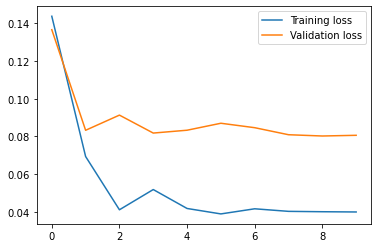

In [9]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [10]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
future = days_future + days_past

# days_past?
prediction_dates = pd.date_range(list(dates)[-future], periods=future, freq=us_bd).tolist()

prediction = model.predict(train_X[-future:])

1/1 [==============================] - 1s 1s/step


In [11]:
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_forecast = scaler.inverse_transform(prediction_copies)[:,0]

In [12]:
forecast_dates = []
for time_i in prediction_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'open':y_forecast})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

In [13]:
original = df[['date', 'open']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-8-1']

/var/folders/5_/bb05t_s57j12tjmc9s6_yg_r0000gn/T/ipykernel_48481/740320029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='open'>

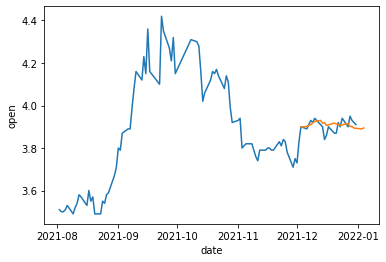

In [14]:
import seaborn as sns

sns.lineplot(original['date'], original['open'])
sns.lineplot(df_forecast['date'], df_forecast['open'])

In [241]:
result = pd.concat([df,df_forecast], axis=0, join="outer")
result

,date,open,close,high,low,volume,code
35,2021-03-01,3.940000,3.97,3.99,3.86,2132957.0,600028
36,2021-03-02,3.910000,3.78,3.91,3.73,3262558.0,600028
37,2021-03-03,3.750000,3.86,3.88,3.75,2360436.0,600028
38,2021-03-04,3.860000,3.85,3.91,3.81,1632436.0,600028
39,2021-03-05,3.920000,3.90,3.98,3.81,2489610.0,600028
...,...,...,...,...,...,...,...
16,2021-12-28 00:00:00,3.901279,NaN,NaN,NaN,NaN,NaN
17,2021-12-29 00:00:00,3.901528,NaN,NaN,NaN,NaN,NaN
18,2021-12-30 00:00:00,3.893606,NaN,NaN,NaN,NaN,NaN
19,2022-01-03 00:00:00,3.889935,NaN,NaN,NaN,NaN,NaN


In [242]:
result.to_csv("600028_ZGSH.csv")

In [15]:
df_forecast.to_csv("600028_ZGSH_pred.csv")

In [15]:
df.to_csv("600028_ZGSH.csv")